# Modelagem Preditiva - IMDB

## Autor: Felipe Alves

Este notebook servirá para construção do modelo utilizado para responder as perguntas do desafio.
No processo, explicarei:

- A seleção das features e as transformações aplicadas nelas.
- O treinamento do algoritmo selecionado (regressão).
- A avaliação do modelo e as métricas utilizadas.
- Os resultados obtidos e o que significam.

Imports:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

Carregarei os dados já tratados pela etapa anterior

In [2]:
df = pd.read_csv('data/desafio_indicium_imdb_tratado.csv')

## Seleção de Features e transformações

Nesta etapa, selecionarei variáveis que podem influenciar a nota IMDB de um filme.
As variáveis escolhidas foram:

- Meta_score - Avaliação da crítica, possui correlação 0.25
- Primary_Genre - Gênero principal do filme, útil para capturar padrões culturais
- Runtime - Duração em minutos, com correlação 0.24
- Certificate - Classificação etária
- No_of_Votes - Número de votos no IMDB (a maior das correlações, com 0.48)
- Director_frequency - Quantidade de filmes do diretor no dataset. Alguns diretores aparecem várias vezes, Scorsese e Nolan por exemplo. Podem indicar uma tendência se esses diretores tiverem boas avaliações.
- Star1_frequency - Quantidade de filmes do ator principal no dataset. Mesma lógica do Director_frequency

Uma observação sobre a No_of_Votes: imagino que, em um projeto real, não usaria. Uma vez que o modelo seria usado para prever as notas de filmes que ainda não foram lançados e essa feature só estaria disponível após o filme ser lançado. Entretanto, para o propósito de responder a pergunta e com o filme que foi usado como exemplo (que já possui esse dado) achei válido.

In [3]:
def create_features(df):
    df_model = df.copy()
    
    director_counts = df_model["Director"].value_counts()
    df_model["Director_frequency"] = df_model["Director"].map(director_counts)
    
    star1_counts = df_model["Star1"].value_counts()
    df_model["Star1_frequency"] = df_model["Star1"].map(star1_counts)
    
    return df_model

df_model = create_features(df)

df_model[["Series_Title", "Director_frequency", "Star1_frequency", "Runtime"]].head()

,Series_Title,Director_frequency,Star1_frequency,Runtime
0,The Godfather,5,2,175.0
1,The Dark Knight,8,8,152.0
2,The Godfather: Part II,5,10,202.0
3,12 Angry Men,5,3,96.0
4,The Lord of the Rings: The Return of the King,5,3,201.0


## Preparando dados para utilização no modelo
- Converterei as features categóricas em numéricas, com o Label Encoding (Primary_Genre, Certificate, Director_frequency e Star1_frequency)
- Definirei a variável alvo (IMDB_Rating)
- Por fim dividirei os dados em dados de treino (80% do dataset) e de teste (20% restantes).

In [4]:
feature_cols = [
    "Meta_score",
    "Runtime",
    "No_of_Votes",
    "Primary_Genre",
    "Certificate",
    "Director_frequency",
    "Star1_frequency"
]

X = df_model[feature_cols].copy()
y = df_model["IMDB_Rating"]

categorical_cols = ["Primary_Genre", "Certificate"]
le_dict = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=pd.cut(y, bins=5))

print("Formato dos dados:")
print(X_train.shape, X_test.shape)
X_train.head()

Formato dos dados:
(798, 7) (200, 7)


,Meta_score,Runtime,No_of_Votes,Primary_Genre,Certificate,Director_frequency,Star1_frequency
256,77.08046,98.0,150345,5,14,1,1
992,96.00000,87.0,40351,4,12,1,1
427,75.00000,131.0,68926,6,1,2,3
428,63.00000,172.0,205425,3,12,2,2
58,78.00000,181.0,809955,0,14,4,4


## Treinamento do Modelo

Optei por utilizar o RandomForest devido a algumas vantagens:

- Modelo robusto que serve bem para dados tabulares e diversos (dataset contém variáveis categóricas e numéricas)
- Menos sensível a outliers.
- Fornece uma medida de importância das variáveis.

Existem desvantagens também:

- Dificil interpretabilidade (entender o por quê da predição ser o que é)
- Pode ter overfitting se os dados tiverem ruído

Treinarei o modelo com 200 árvores de decisão, profundidade máxima de 15 e um número mínimo de amostras por folhas = 2.

In [5]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=1
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=200, random_state=1)

## Avaliação e Resultados

Como métrica, resolvi usar o MAE (Mean Absolute Error), ela servirá para mostrar o erro absoluto médio entre as notas do dataset e as notas que o modelo previu. Utilizei ele por sua fácil interpretação.

In [6]:
y_pred_test = rf_model.predict(X_test)

# Calcular MAE
mae_test = mean_absolute_error(y_test, y_pred_test)

print("Perfomance do modelo:")
print(f"MAE (Teste): {mae_test:.3f}")

Perfomance do modelo:
MAE (Teste): 0.172



Importância das variáveis:
              feature  importance
2         No_of_Votes    0.488996
0          Meta_score    0.188791
1             Runtime    0.140025
5  Director_frequency    0.051587
4         Certificate    0.047747
3       Primary_Genre    0.046175
6     Star1_frequency    0.036679


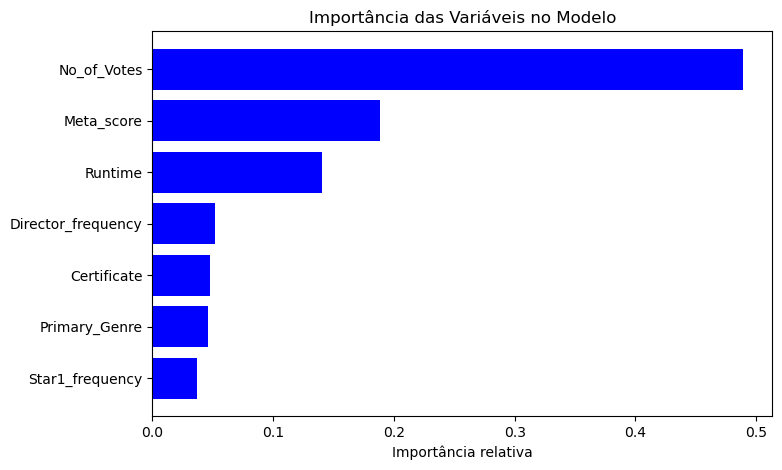

In [7]:
# Importância das features
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nImportância das variáveis:")
print(feature_importance)

# Visualização
plt.figure(figsize=(8, 5))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='b')
plt.gca().invert_yaxis()
plt.title('Importância das Variáveis no Modelo')
plt.xlabel('Importância relativa')
plt.show()

Como podemos ver, o modelo apresentou um MAE de 0.172, o que é ótimo! Isso significa que, em média o modelo erra 0.172 para mais ou para menos. Considerando que as notas variam de 0 a 10, é um erro completamente aceitável.

Além disso, podemos ver a importância das features, No_of_Votes de fato é a mais importante (por muito), enquanto meta_score e runtime tiveram importancia média. As demais serviram como auxílio, mas não são indispensáveis.

## Pergunta 4:

Para prever a nota IMDB do filme indicado no desafio, basta utilizar o modelo criado.

Primeiro, aplicarei o mesmo pré-processamento que aplique no EDA para esse novo filme. Farei isso criando uma função, para facilitar a previsão de novos filmes que poderiam aparecer.

In [8]:
def preprocess_new_data(df, df_original):
    
    df = df.copy()

    df = df.dropna(subset=["Released_Year"])

    df["Certificate"] = df["Certificate"].fillna("Unknown")

    df['Primary_Genre'] = df['Genre'].str.split(',').str[0].str.strip()

    meta_means = df_original.groupby("Primary_Genre")["Meta_score"].mean()
    df['Meta_score'] = df.apply(
        lambda row: row['Meta_score'] if pd.notna(row['Meta_score']) 
                    else meta_means.get(row['Primary_Genre'], meta_means.mean()), 
        axis=1
    )
    
    df['Gross'] = df['Gross'].astype(str).str.replace(',', '', regex=False)
    df['Gross'] = pd.to_numeric(df['Gross'], errors='coerce')

    df['has_gross'] = df['Gross'].notna().astype(int)
    df['Gross'] = df['Gross'].fillna(0)
    
    return df

Agora, utilizarei essa função para fazer o pré-processamento do filme e testar o modelo com ele.

In [9]:
new_film = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': 1994,
    'Certificate': 'A',
    'Runtime': 142,
    'Genre': 'Drama',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'No_of_Votes': 2343110,
    'Gross': 28341469
}
new_df = pd.DataFrame([new_film])

new_df = preprocess_new_data(new_df, df)

# Concatenando ao dataset já processado
df_temp = pd.concat([df_model, new_df], ignore_index=True)
df_temp = create_features(df_temp)

X_new = df_temp.loc[df_temp["Series_Title"] == "The Shawshank Redemption", feature_cols].copy()

for col in categorical_cols:
    X_new[col] = le_dict[col].transform(X_new[col].astype(str))

pred = rf_model.predict(X_new)[0]
print(f"Previsão IMDB para {new_film['Series_Title']}: {pred:.2f}")

Previsão IMDB para The Shawshank Redemption: 8.71


Com uma breve pesquisa, vi que a nota do filme no IMDB é 9.3, isso significa uma margem de erro de 0.6 nesse caso específico. Considerando o MAE de 0.172, faz sentido. Lembrando que o MAE é uma média, então é normal que alguns filmes tenham margens menores e outros filmes tenham margens maiores.

# Resumindo: Respostas para a pergunta 3

- Fiz a previsão utilizando o modelo RandomForest. Para a construção dele, usei um conjunto de variáveis objetivas e categóricas.
- A resposta para a segunda pergunta da 3 está no começo do notebook, na seção "Seleções de features e transformações".
- O problema é do tipo de regressão, uma vez que a resposta esperada está em um intervalo de 0 a 10.
- As últimas perguntas estão respondidas nas seções "Treinamento do Modelo" e "Avaliação e Resultados" respectivamente.

## Salvando o modelo no formato pkl

In [10]:
import pickle

with open('./models/imdb_rating_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('./models/label_encoders.pkl', 'wb') as f:
    pickle.dump(le_dict, f)